In [1]:
"""
https://tradingstrategyguides.com/swing-trading-strategies-that-work/

It's based on classic technical indicator called "Bollinger Bands". It's construced as:
- central moving average (MA), which is a simple moving average.
- two other moving averages at a distance of +-2 standard dev. away from the central MA

There are following steps:
#1: Wait for the price to touch the Upper Bollinger Band. It (in theory) means that price is price moving into 
overbought territory. That is - price is relatively too high for given stock and will probably go down.

Step #2: Wait for the price to Break below the Middle Bollinger Bands. Such a move acts as confirmation of the 
shift in market sentiment. In other words - investors realized that stock is overbought and started seeling
(hence price is going down).

Important Note: the "breakout" of the central MA should be so called "Big Bold Breakout Candle". That is
closing price is near the Low Range of the Candlestick. One should sell at the closing price of the Breakout Candle.

This "Breakout Candle" is meant to confirm that there are real sellers, that is: there is an assumption that such a
strong move down indicates actual changed sentiment of sellers rather that just its the "natural" fluctation 
of the price.

Step #4: Set-up "Protective Stop Loss" above the Breakout Candle
As a stop loss high of the entry candle is taken. Rationalities behind it is that during entry move one assumes 
candle as representation of real market sentiment and sellers. If high of this candle is "broken" that is
clear sign that in this case there was no real sellers sentiment shift.

Step #5: Take Profit once we break and close back above the middle Bollinger Bands (central MA)

THAT WAS SHORT TRADE EXAMPLE. FOR LONG TRADES THERE ARE SAME STEPS BUT IN REVERSED ORDER

My personal thought:
- It would be nice to have some sort of expected range of the move. That is - one is setting up stop loss which is 
fine, but at the same time there is no expected range of the move in preferable direction. That makes calculating
reward-to-risk ratio imposibble.
- If one have multiple trades to choose (and properly diversify portfolio) then given strategy gives no clues about
which trade choose. R2R ratio would be helpfull.
- That problem occures not only when we have couple of trades to choose in the same day. One can "loose" future trade
by choosing the one today - which in reality one is not aware of having small R2RR.
- Having method to estimate R2RR and uses it as an additional filter for trades could be good enhacemnet for that
strategy.

""";

In [32]:
# built-in
import sys
sys.path.insert(0, '/Users/slaw/osobiste/trading')

# 3rd party
import numpy as np
from mpl_finance import candlestick_ohlc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# custom
import gpw_data

# to allow zoom plots
%matplotlib notebook  

In [3]:
import importlib
importlib.reload(gpw_data)

<module 'gpw_data' from '/Users/slaw/osobiste/trading/gpw_data.py'>

In [4]:
gpwdata = gpw_data.GPWData(pricing_data_path='../pricing_data')
wig_20_stocks = gpwdata.load(index='WIG20')

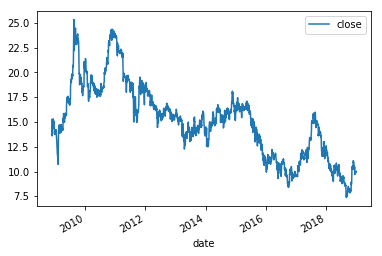

In [5]:
# tests for single stock for now
symbol = wig_20_stocks['ENEA']
symbol.plot(y=['close']);

In [45]:
def get_bollinger_bands(df, ma_type='simple', time_window=20, no_std=2, price_label='close', with_nans=False):
    df = df.copy()
    # central moving average
    if ma_type == 'simple':
        df.loc[:, 'central_ma'] = df[price_label].rolling(window=time_window).mean()
    elif ma_type == 'exp':
        df.loc[:, 'central_ma'] = df[price_label].ewm(span=time_window, adjust=False).mean()
    # standard deviation and remaining averages
    df.loc[:, 'ma_std'] = df[price_label].rolling(window=time_window).std()
    df.loc[:, 'lower_ma'] = df['central_ma'] - (no_std*df['ma_std'])
    df.loc[:, 'upper_ma'] = df['central_ma'] + (no_std*df['ma_std'])

    if with_nans:
        return df
    df_no_nans = df[~df['ma_std'].isnull()]
    return df_no_nans

    
df_bands = get_bollinger_bands(symbol)
print(df_bands.head(10))

             open   high    low  close  volume  central_ma    ma_std  \
date                                                                   
2008-12-12  15.00  15.10  15.00  15.06    9074     14.7020  0.524842   
2008-12-15  15.00  15.14  15.00  15.00   18038     14.6895  0.513968   
2008-12-16  15.00  15.00  14.90  15.00   23185     14.7395  0.491512   
2008-12-17  14.97  14.97  14.25  14.25    9286     14.7500  0.477835   
2008-12-18  14.44  14.44  13.76  13.87    6735     14.7635  0.446416   
2008-12-19  13.87  14.13  13.80  13.90    6118     14.7585  0.455877   
2008-12-22  14.00  14.00  13.75  13.76    7423     14.7265  0.502450   
2008-12-23  13.75  13.80  13.60  13.80   21717     14.6915  0.541890   
2008-12-29  13.90  13.90  13.62  13.79   13527     14.6660  0.572422   
2008-12-30  13.83  13.90  13.71  13.89   33524     14.6430  0.594599   

             lower_ma   upper_ma  
date                              
2008-12-12  13.652316  15.751684  
2008-12-15  13.661564  15.7174

In [17]:
"""
"Big Bold Candle" is actually really unclear. In the article it is mentioned that is should have (for short) 
"closing price is near the Low Range of the Candlestic". The thing is that "Low Range" is the thin line below the 
body - it's also called "wick" or "shadow". But in what sense it's big? Closing price may be  near lowest price but 
the whole price range (from high to low - indication of volatility) may be really "small"...
I could not find any canlde formation actually called "big bold...". I think authours could refer to 2 formations
called "Big Black Candle" and "Big White Candle". Thoe are candles with long bodies. 

Big Black Candle - Has an unusually long black body with a wide range between high and low. Prices open near the
high and close near the low. Considered a bearish pattern.

Big White Candle - Has an unusually long white body with a wide range between high and low of the day. Prices open 
near the low and close near the high. Considered a bullish pattern.

The problem with those definitions is - what it means "unusually long (...) body"? How to quantify that? I could
not find anything more specific than adjectives like "long", "big" etc...

I'd say it should be parametrized somewhow... Or taken from distibution of ranges from the past... I imagine 
that "long" candles may be for stocks quite "normal" where for the others they are super rare. 

As a proxy distribution I can take average range and standard deviation in last X days. It may be the same period
I'm taking for moving average or the other. Then I can see how many standard deviations from average given candle's
range is. If it's above certain threshold - consider it as "big".
""";

In [46]:
# next -> define this "breakout" candle which I'll be using as a confirmation of the entry
def get_big_candles(df, time_window=20, no_std=2, with_nans=False):
    """
    That func can be later on joined with the one which is calculating bollinger bands
    """
    df = df.copy()
    # get lenght of clandles body, it's average and std dev
    df.loc[:, 'candle_range'] = abs(df['close'] - df['open'])
    df.loc[:, 'candle_range_avg'] = df['candle_range'].rolling(window=time_window).mean()
    df.loc[:, 'candle_range_std'] = df['candle_range'].rolling(window=time_window).std()
    
    # identify "long" candles
    df.loc[:, 'is_long'] = abs(df['candle_range_avg'] - df['candle_range']) > no_std*df['candle_range_std']
    
    if with_nans:
        return df
    df_no_nans = df[~df['candle_range_std'].isnull()]
    return df_no_nans
    
    
df_bands = get_big_candles(df_bands)
print(df_bands.head(10))

             open   high    low  close  volume  central_ma    ma_std  \
date                                                                   
2009-01-15  13.40  13.40  13.01  13.10  136818     13.9895  0.523294   
2009-01-16  13.21  13.21  13.01  13.07    9181     13.8900  0.497594   
2009-01-19  13.03  13.03  12.54  12.66   43256     13.7730  0.497965   
2009-01-20  12.81  12.84  12.40  12.48   38780     13.6470  0.489910   
2009-01-21  11.72  12.35  11.69  12.30   34045     13.5495  0.553501   
2009-01-22  12.44  12.44  11.99  12.11    4505     13.4615  0.633929   
2009-01-23  12.25  12.25  11.55  11.85   34791     13.3590  0.719283   
2009-01-26  11.94  11.94  11.51  11.60    7291     13.2510  0.812079   
2009-01-27  11.64  11.74  11.54  11.60    6051     13.1410  0.879964   
2009-01-28  11.60  11.60  11.49  11.50   32591     13.0265  0.938135   

             lower_ma   upper_ma  candle_range  candle_range_avg  \
date                                                               

<IPython.core.display.Javascript object>


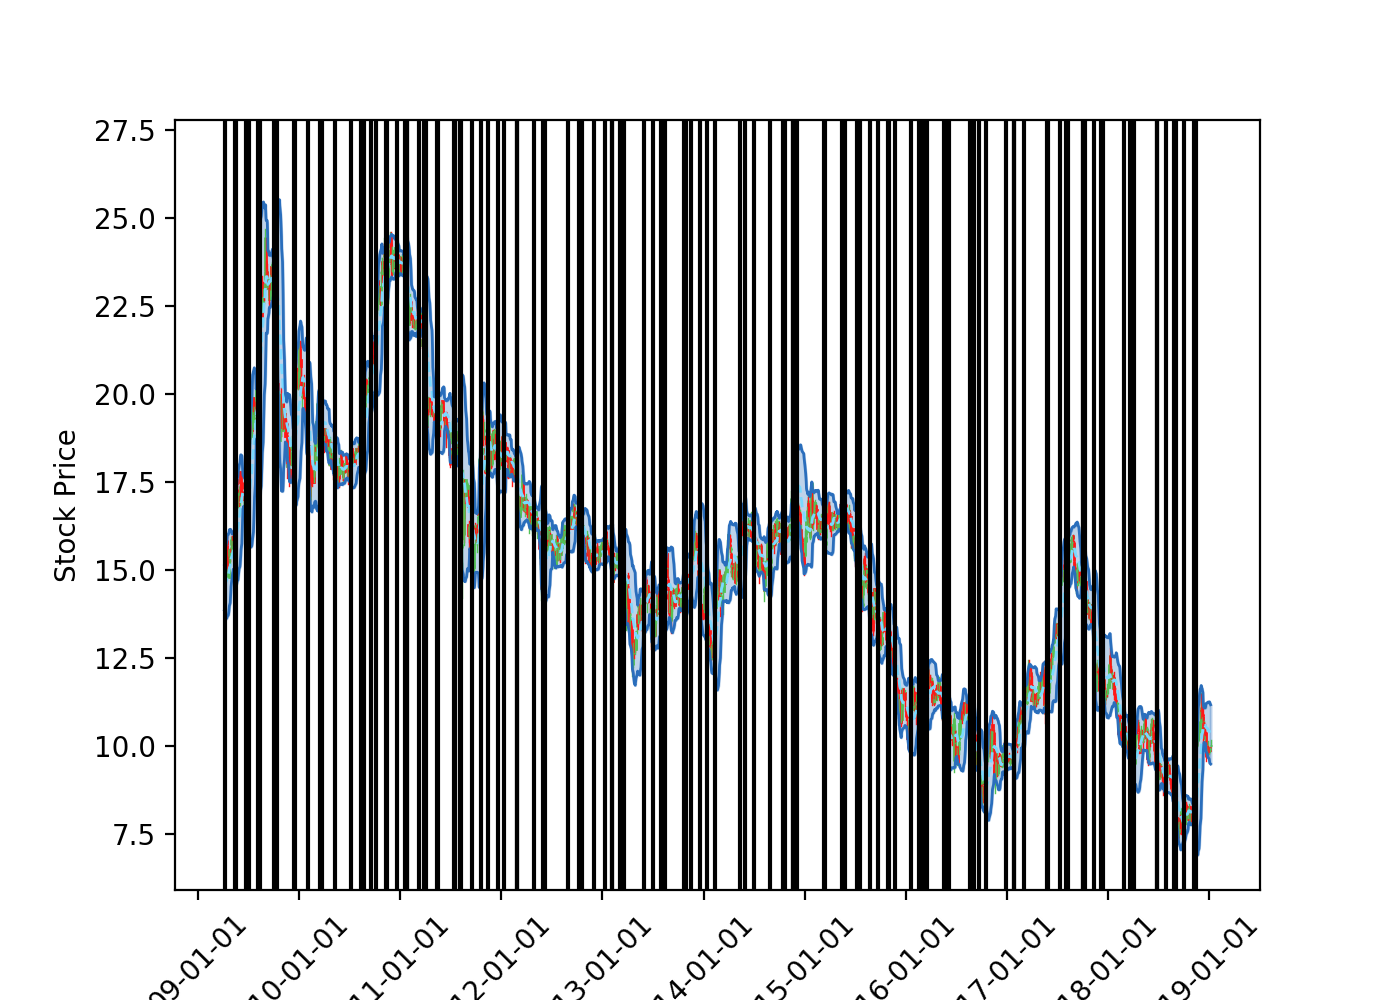

In [30]:
def plot_chart(with_candles=True):
    # prepare df for candle chart
    df_bands.loc[:, 'date'] = pd.to_datetime(df_bands.index)
    df_bands.loc[:, 'date'] = df_bands['date'].apply(mdates.date2num)
    df_for_candle = df_bands[['date', 'open', 'high', 'low', 'close']]

    # plt data
    fig_1, ax_1 = plt.subplots(figsize=(7,5))

    ax_1.xaxis_date()
    ax_1.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))
    candlestick_ohlc(ax_1, df_for_candle.values, width=.6, colorup='#53c156', colordown='#ff1717')

    # add central MA as dotted line
    ax_1.plot(df_bands['central_ma'], color='#7ad9ff', linestyle='--', linewidth=1)

    # add upper/lower band and fill spacing between
    ax_1.plot(df_bands['lower_ma'], color='#2a6ebc', linestyle='-', linewidth=1)
    ax_1.plot(df_bands['upper_ma'], color='#2a6ebc', linestyle='-', linewidth=1)
    ax_1.fill_between(df_bands['date'], df_bands['lower_ma'], df_bands['upper_ma'], color='#2a6ebc', alpha=0.3)

    if with_candles == True:
        # add vertical lines to mark "Big Bold" candles
        long_candles = df_bands[df_bands['is_long']].index.tolist()
        for candle in long_candles:
            ax_1.axvline(candle, color='black', linestyle='-')

    plt.xticks(rotation=45)
    plt.ylabel('Stock Price')
    plt.xlabel('Date')
    plt.show()

plot_chart()

In [ ]:
# generate entry/exit signals and add stop loss

Should stop loss be coded in signals? Or it should be a feature of backtester... ?

If in strategy - I'll have to handle that logic evey time. From the other hand... how to implement that
so that backester is smart enough and I actually save the work...?

Also... isn't "false" signal - that is signal for entry which is later on stopped important in signal generation
part...? Let's say strategy generates A LOT of false signals. Is it better to know it at the moment of signals
development or later during the backtest?

If I have stop loss handling as a signal backtester will remain quite simple - it will just execute instructions
of the entries and exits (and position size but that is handled be position sizer).

When I'll be optimizing I'll prefer to run full backest to see what is actually happening. So I'd prefer to avoid
optiomization of signal development and then second optimization of complete strategy results. It means that
all the metrics which will indicate strategy performance will be calculated there...

What about generating: entry, exit, stop_loss. Then, in execution backtester will act accoringly:
1) Sell if stop loss triggered
2) Ignore "true" exit signal as you've already did it

That would be actually nice as then as a result of backfill I can see how many lost trades there was due, how many
of them were due to the fact that stop loss was executed? How many of them did not hit stop loss? How many of them
were theoretically successfull but at the end brought losses? Those all could be very useful.

In [12]:
"""
some random ideas:
- Need to check how many entry signals is being generated. Idealy for many stock and then get sort of distibution
"""